In [1]:
# !pip install -U transformers accelerate datasets git+https://github.com/huggingface/diffusers Pillow==9.4.0 torchmetrics wandb

In [2]:
# from local_secrets import hf_token, wandb_key
# from huggingface_hub import login
# import wandb

# login(token=hf_token)
# wandb.login(key=wandb_key)

In [3]:
import torch, torch.nn.functional as F, random, wandb, time
import torchvision.transforms as T
from torchvision import transforms
from diffusers import AutoencoderDC, SanaTransformer2DModel
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoModel, AutoTokenizer, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm
from torch.utils.data import DataLoader

from utils import latent_to_PIL, make_grid, encode_prompt, dcae_scalingf, pil_clipscore, cifar10_labels, free_memory

seed = 42
set_seed(seed)

In [4]:
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

transformer = SanaTransformer2DModel.from_config("transformer_Sana-7L-MBERT_config.json").to(device).to(dtype)
text_encoder = AutoModel.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=dtype).to(device)
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=dtype)

model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)

/home/g/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.load_config(...) followed by <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


# Load dataset

In [5]:
ds = load_dataset("g-ronimo/CIFAR10-128-latents_dc-ae-f32c32-sana-1.0")
ds["train"]

Dataset({
    features: ['label', 'latent'],
    num_rows: 50000
})

In [6]:
# Pre-encode all the labels
labels = cifar10_labels
labels_encoded={k: encode_prompt(labels[k], tokenizer, text_encoder) for k in labels}

len(labels_encoded), len(labels_encoded[0]), labels_encoded[0][0].shape, labels_encoded[0][1].shape

(10, 2, torch.Size([1, 300, 768]), torch.Size([1, 300]))

In [7]:
# Define and test our collate fn
def collate(items):
    labels = [i["label"] for i in items]
    latents = torch.cat([torch.Tensor(i["latent"]) for i in items]).to(dtype).to(device)
    prompts_encoded = torch.cat([labels_encoded[label][0] for label in labels])
    prompts_atnmask = torch.cat([labels_encoded[label][1] for label in labels])

    return labels, latents, prompts_encoded, prompts_atnmask

dataloader = DataLoader(ds["train"], batch_size=2, shuffle=True, generator = torch.manual_seed(seed), collate_fn=collate)
labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader))
len(labels), latents.mean(), latents.shape, prompts_encoded.shape, prompts_atnmask.shape

(2,
 tensor(-0.2373, device='cuda:0', dtype=torch.bfloat16),
 torch.Size([2, 32, 4, 4]),
 torch.Size([2, 300, 768]),
 torch.Size([2, 300]))

In [8]:
# # create a test batch
# testbatch = []
# seen = {}

# for i in range(100):
#     item = ds["train"][i]
#     label, latent = item["label"], item["latent"]
#     if not label in seen:
#         print("Adding ", label)
#         seen[label] = True
#         testbatch.append(item)
#     if len(testbatch) == 10: break
# testbatch = collate(testbatch)

In [9]:
# labels, latents, prompts_encoded, prompts_atnmask = testbatch

# print(labels)
# latents_decoded = [latent_to_PIL(latents[i,None], dcae) for i in range(len(labels))]
# display(make_grid(latents_decoded, 2, 5).resize((800,300)))


# Helpers for eval and generate

In [10]:
def get_timesteps(num_steps):
    dt = 1.0 / num_steps
    timesteps = [int(i/num_steps*1000) for i in range(num_steps, 0, -1)]
    return dt, timesteps
get_timesteps(3)

(0.3333333333333333, [1000, 666, 333])

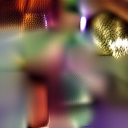

In [11]:
def generate(prompt, latent_dim=[1, 32, 4, 4], num_steps=100, latent_seed=42):
    dt, timesteps = get_timesteps(num_steps)
    # print(timesteps)
    prompt_encoded, prompt_atnmask = encode_prompt(prompt, tokenizer, text_encoder)
    latent = torch.randn(latent_dim, generator = torch.manual_seed(latent_seed)).to(dtype).to(device)
    for t in timesteps:
        t = torch.Tensor([t]).to(dtype).to(device)
        with torch.no_grad():
            noise_pred = transformer(latent, encoder_hidden_states=prompt_encoded, timestep=t, encoder_attention_mask=prompt_atnmask, return_dict=False)[0]
        latent = latent - dt * noise_pred

    return latent_to_PIL(latent / dcae_scalingf, dcae)

generate("horse", num_steps=10, latent_seed=43).resize((128,128))

In [12]:
def eval_loss(data_val, batch_size=128, timesteps=1000):
    losses = []
    eval_dataloader = iter(DataLoader(data_val, batch_size=batch_size, shuffle=False, collate_fn=collate))

    for batch_num, (labels, latents, prompts_encoded, prompts_atnmask) in tqdm(enumerate(eval_dataloader), "eval_loss"):
        noise = torch.randn_like(latents)
        t = torch.randint(1, timesteps + 1, (latents.size(0),)).to(device)
        tperc = t.view([latents.size(0), *([1] * len(latents.shape[1:]))])/timesteps
        latents_noisy = (1 - tperc) * latents + tperc * noise # (1-noise_level) * latent + noise_level * noise
        latents_noisy = latents_noisy * dcae_scalingf
        with torch.no_grad():
            noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
    
        loss = F.mse_loss(noise_pred, noise - latents)
        losses.append(loss.item())  
    return sum(losses)/len(losses)

eval_loss(ds["test"])

eval_loss: 79it [00:10,  7.83it/s]


6.755537974683544

In [13]:
def eval_clipscore(images):
    prompts = [cifar10_labels[k] for k in cifar10_labels]
    return pil_clipscore(images, prompts)

images = [generate(p) for p in tqdm([cifar10_labels[k] for k in cifar10_labels], "eval_images")]
eval_clipscore(images)

eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


22.364389419555664

# Train

In [14]:
log_wandb = True
lr = 5e-4
# bs = 64
bs = 384
epochs = 1000
timesteps_training = 1000
steps_log, steps_eval = 40, 400
# steps_log, steps_eval = 10, 20

splits = list(ds.keys())
data_train, data_val = ds[splits[0]], ds[splits[1]]

steps_epoch = len(data_train) // bs

dataloader = DataLoader(data_train, batch_size=bs, shuffle=True, generator = torch.manual_seed(seed), collate_fn=collate)
optimizer = torch.optim.AdamW(transformer.parameters(), lr=lr)

model_size = sum(p.numel() for p in transformer.parameters() if p.requires_grad)
print(f"Model parameters: {model_size / 1e6:.2f}M")
print(f"{len(splits)} splits: {splits}", [len(ds[s]) for s in splits])
assert len(splits)==2 

Model parameters: 156.41M
2 splits: ['train', 'test'] [50000, 10000]


In [15]:
if log_wandb: 
    if wandb.run is not None: wandb.finish()
    wandb.init(project="Hana", name=f"Z-{model_size / 1e6:.2f}M_CIFAR10-128_LR-{lr}_BS-{bs}_TS-{timesteps_training}_my3090").log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb") or path.endswith(".json"))

step = 0
last_step_time = time.time()

for _ in range(epochs):
    for labels, latents, prompts_encoded, prompts_atnmask in dataloader:
        noise = torch.randn_like(latents)
        t = torch.randint(1, timesteps_training + 1, (latents.size(0),)).to(device)
        tperc = t.view([latents.size(0), *([1] * len(latents.shape[1:]))])/timesteps_training
        latents = latents * dcae_scalingf
        latents_noisy = (1 - tperc) * latents + tperc * noise # (1-noise_level) * latent + noise_level * noise
        noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
    
        loss = F.mse_loss(noise_pred, noise - latents)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()    
        
        if step % steps_log == 0:
            loss_train = loss.item()
            step_time = (time.time() - last_step_time) / steps_log * 1000
            sample_tp = bs * steps_log / (time.time() - last_step_time)
            print(f"step {step}, epoch: {step / steps_epoch:.4f}, train loss: {loss_train:.4f}, grad_norm: {grad_norm:.2f}, {step_time:.2f}ms/step, {sample_tp:.2f}samples/sec")
            if log_wandb: wandb.log({"loss_train": loss_train, "grad_norm": grad_norm, "step_time": step_time, "step": step, "sample_tp": sample_tp, "sample_count": step * bs, "epoch": step / steps_epoch})
            last_step_time = time.time()
    
        if step % steps_eval == 0:
            transformer.eval()
            loss_eval = eval_loss(data_val)
            images_eval = [generate(p) for p in tqdm([cifar10_labels[k] for k in cifar10_labels], "eval_images")]
            clipscore = eval_clipscore(images_eval)
            print(f"step {step}, eval loss: {loss_eval:.4f}, clipscore: {clipscore:.2f}")
            if log_wandb: wandb.log({"loss_eval": loss_eval, "clipscore": clipscore, "images_eval": wandb.Image(make_grid(images_eval, 2, 5)), "step": step, "sample_count": step * bs, "epoch": step / steps_epoch})
            transformer.train()
        step += 1

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: g-ronimo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


step 0, epoch: 0.0000, train loss: 6.7188, grad_norm: 20.00, 20.32ms/step, 18893.02samples/sec


eval_loss: 79it [00:10,  7.75it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.16it/s]


step 0, eval loss: 11.6915, clipscore: 23.88
step 40, epoch: 0.3077, train loss: 4.3438, grad_norm: 1.90, 1155.15ms/step, 332.42samples/sec
step 80, epoch: 0.6154, train loss: 3.3594, grad_norm: 1.24, 568.91ms/step, 674.97samples/sec
step 120, epoch: 0.9231, train loss: 3.1562, grad_norm: 0.89, 581.78ms/step, 660.04samples/sec
step 160, epoch: 1.2308, train loss: 3.1562, grad_norm: 0.82, 566.13ms/step, 678.29samples/sec
step 200, epoch: 1.5385, train loss: 2.9844, grad_norm: 0.71, 577.88ms/step, 664.49samples/sec
step 240, epoch: 1.8462, train loss: 2.9531, grad_norm: 0.67, 574.29ms/step, 668.65samples/sec
step 280, epoch: 2.1538, train loss: 2.8438, grad_norm: 0.59, 565.70ms/step, 678.81samples/sec
step 320, epoch: 2.4615, train loss: 2.9375, grad_norm: 0.69, 602.08ms/step, 637.79samples/sec
step 360, epoch: 2.7692, train loss: 3.0000, grad_norm: 0.62, 592.91ms/step, 647.66samples/sec
step 400, epoch: 3.0769, train loss: 2.8906, grad_norm: 0.62, 596.38ms/step, 643.88samples/sec


eval_loss: 79it [00:10,  7.59it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


step 400, eval loss: 2.8892, clipscore: 23.90
step 440, epoch: 3.3846, train loss: 2.8438, grad_norm: 0.52, 1152.00ms/step, 333.33samples/sec
step 480, epoch: 3.6923, train loss: 2.7500, grad_norm: 0.57, 589.87ms/step, 650.99samples/sec
step 520, epoch: 4.0000, train loss: 2.8594, grad_norm: 0.54, 600.11ms/step, 639.89samples/sec
step 560, epoch: 4.3077, train loss: 2.9844, grad_norm: 0.58, 586.09ms/step, 655.19samples/sec
step 600, epoch: 4.6154, train loss: 2.8750, grad_norm: 0.57, 598.94ms/step, 641.13samples/sec
step 640, epoch: 4.9231, train loss: 2.8281, grad_norm: 0.52, 591.57ms/step, 649.12samples/sec
step 680, epoch: 5.2308, train loss: 2.8594, grad_norm: 0.59, 597.22ms/step, 642.98samples/sec
step 720, epoch: 5.5385, train loss: 2.8125, grad_norm: 0.55, 591.98ms/step, 648.67samples/sec
step 760, epoch: 5.8462, train loss: 2.8906, grad_norm: 0.49, 600.87ms/step, 639.08samples/sec
step 800, epoch: 6.1538, train loss: 2.8281, grad_norm: 0.52, 584.35ms/step, 657.14samples/sec


eval_loss: 79it [00:11,  7.17it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


step 800, eval loss: 2.8214, clipscore: 23.73
step 840, epoch: 6.4615, train loss: 2.7969, grad_norm: 0.51, 1161.80ms/step, 330.52samples/sec
step 880, epoch: 6.7692, train loss: 2.7656, grad_norm: 0.50, 602.62ms/step, 637.22samples/sec
step 920, epoch: 7.0769, train loss: 2.8906, grad_norm: 0.52, 582.72ms/step, 658.98samples/sec
step 960, epoch: 7.3846, train loss: 2.9219, grad_norm: 0.46, 601.66ms/step, 638.23samples/sec
step 1000, epoch: 7.6923, train loss: 2.8125, grad_norm: 0.48, 584.11ms/step, 657.41samples/sec
step 1040, epoch: 8.0000, train loss: 2.7812, grad_norm: 0.53, 590.99ms/step, 649.76samples/sec
step 1080, epoch: 8.3077, train loss: 2.7344, grad_norm: 0.48, 586.44ms/step, 654.80samples/sec
step 1120, epoch: 8.6154, train loss: 2.7812, grad_norm: 0.45, 602.24ms/step, 637.62samples/sec
step 1160, epoch: 8.9231, train loss: 2.8750, grad_norm: 0.44, 600.81ms/step, 639.14samples/sec
step 1200, epoch: 9.2308, train loss: 2.8594, grad_norm: 0.44, 585.88ms/step, 655.42samples/s

eval_loss: 79it [00:10,  7.50it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


step 1200, eval loss: 2.8006, clipscore: 23.98
step 1240, epoch: 9.5385, train loss: 2.7188, grad_norm: 0.47, 1130.43ms/step, 339.69samples/sec
step 1280, epoch: 9.8462, train loss: 2.7188, grad_norm: 0.49, 575.46ms/step, 667.29samples/sec
step 1320, epoch: 10.1538, train loss: 2.8750, grad_norm: 0.48, 565.69ms/step, 678.82samples/sec
step 1360, epoch: 10.4615, train loss: 2.8438, grad_norm: 0.46, 571.64ms/step, 671.75samples/sec
step 1400, epoch: 10.7692, train loss: 2.7500, grad_norm: 0.43, 580.46ms/step, 661.54samples/sec
step 1440, epoch: 11.0769, train loss: 2.6562, grad_norm: 0.77, 561.21ms/step, 684.24samples/sec
step 1480, epoch: 11.3846, train loss: 2.7188, grad_norm: 0.48, 578.96ms/step, 663.26samples/sec
step 1520, epoch: 11.6923, train loss: 2.7656, grad_norm: 0.42, 577.84ms/step, 664.55samples/sec
step 1560, epoch: 12.0000, train loss: 2.8438, grad_norm: 0.42, 572.90ms/step, 670.28samples/sec
step 1600, epoch: 12.3077, train loss: 2.7969, grad_norm: 0.41, 577.95ms/step, 66

eval_loss: 79it [00:10,  7.60it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]


step 1600, eval loss: 2.7852, clipscore: 24.22
step 1640, epoch: 12.6154, train loss: 2.7344, grad_norm: 0.47, 1139.79ms/step, 336.90samples/sec
step 1680, epoch: 12.9231, train loss: 2.7188, grad_norm: 0.48, 570.49ms/step, 673.11samples/sec
step 1720, epoch: 13.2308, train loss: 2.8594, grad_norm: 0.48, 563.63ms/step, 681.29samples/sec
step 1760, epoch: 13.5385, train loss: 2.8906, grad_norm: 0.41, 597.12ms/step, 643.09samples/sec
step 1800, epoch: 13.8462, train loss: 2.7812, grad_norm: 0.45, 577.18ms/step, 665.31samples/sec
step 1840, epoch: 14.1538, train loss: 2.7344, grad_norm: 0.44, 566.93ms/step, 677.33samples/sec
step 1880, epoch: 14.4615, train loss: 2.7031, grad_norm: 0.40, 576.32ms/step, 666.30samples/sec
step 1920, epoch: 14.7692, train loss: 2.7500, grad_norm: 0.41, 570.51ms/step, 673.08samples/sec
step 1960, epoch: 15.0769, train loss: 2.8125, grad_norm: 0.42, 583.50ms/step, 658.10samples/sec
step 2000, epoch: 15.3846, train loss: 2.7656, grad_norm: 0.41, 567.16ms/step, 

eval_loss: 79it [00:10,  7.55it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


step 2000, eval loss: 2.7714, clipscore: 24.29
step 2040, epoch: 15.6923, train loss: 2.7031, grad_norm: 0.47, 1128.13ms/step, 340.39samples/sec
step 2080, epoch: 16.0000, train loss: 2.7188, grad_norm: 0.46, 575.85ms/step, 666.84samples/sec
step 2120, epoch: 16.3077, train loss: 2.8281, grad_norm: 0.52, 563.92ms/step, 680.95samples/sec
step 2160, epoch: 16.6154, train loss: 2.8750, grad_norm: 0.44, 575.19ms/step, 667.61samples/sec
step 2200, epoch: 16.9231, train loss: 2.7812, grad_norm: 0.41, 568.84ms/step, 675.06samples/sec
step 2240, epoch: 17.2308, train loss: 2.7344, grad_norm: 0.38, 573.05ms/step, 670.10samples/sec
step 2280, epoch: 17.5385, train loss: 2.6719, grad_norm: 0.44, 570.72ms/step, 672.84samples/sec
step 2320, epoch: 17.8462, train loss: 2.7656, grad_norm: 0.44, 574.76ms/step, 668.10samples/sec
step 2360, epoch: 18.1538, train loss: 2.7188, grad_norm: 0.43, 559.79ms/step, 685.97samples/sec
step 2400, epoch: 18.4615, train loss: 2.7656, grad_norm: 0.40, 578.55ms/step, 

eval_loss: 79it [00:10,  7.76it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


step 2400, eval loss: 2.7654, clipscore: 24.13
step 2440, epoch: 18.7692, train loss: 2.6875, grad_norm: 0.41, 1130.68ms/step, 339.62samples/sec
step 2480, epoch: 19.0769, train loss: 2.6719, grad_norm: 0.48, 575.65ms/step, 667.07samples/sec
step 2520, epoch: 19.3846, train loss: 2.8438, grad_norm: 0.40, 563.15ms/step, 681.88samples/sec
step 2560, epoch: 19.6923, train loss: 2.8438, grad_norm: 0.38, 577.19ms/step, 665.29samples/sec
step 2600, epoch: 20.0000, train loss: 2.7344, grad_norm: 0.40, 570.44ms/step, 673.16samples/sec
step 2640, epoch: 20.3077, train loss: 2.7656, grad_norm: 0.40, 569.89ms/step, 673.82samples/sec
step 2680, epoch: 20.6154, train loss: 2.6875, grad_norm: 0.39, 569.87ms/step, 673.84samples/sec
step 2720, epoch: 20.9231, train loss: 2.7031, grad_norm: 0.42, 577.79ms/step, 664.61samples/sec
step 2760, epoch: 21.2308, train loss: 2.7188, grad_norm: 0.41, 563.16ms/step, 681.87samples/sec
step 2800, epoch: 21.5385, train loss: 2.7500, grad_norm: 0.37, 575.52ms/step, 

eval_loss: 79it [00:10,  7.84it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


step 2800, eval loss: 2.7585, clipscore: 23.58
step 2840, epoch: 21.8462, train loss: 2.6562, grad_norm: 0.38, 1136.74ms/step, 337.81samples/sec
step 2880, epoch: 22.1538, train loss: 2.6562, grad_norm: 0.40, 592.44ms/step, 648.17samples/sec
step 2920, epoch: 22.4615, train loss: 2.7656, grad_norm: 0.39, 593.17ms/step, 647.37samples/sec
step 2960, epoch: 22.7692, train loss: 2.8438, grad_norm: 0.42, 587.68ms/step, 653.42samples/sec
step 3000, epoch: 23.0769, train loss: 2.6875, grad_norm: 0.40, 578.66ms/step, 663.60samples/sec
step 3040, epoch: 23.3846, train loss: 2.7344, grad_norm: 0.41, 565.77ms/step, 678.72samples/sec
step 3080, epoch: 23.6923, train loss: 2.6562, grad_norm: 0.36, 575.59ms/step, 667.14samples/sec
step 3120, epoch: 24.0000, train loss: 2.7031, grad_norm: 0.40, 570.45ms/step, 673.16samples/sec
step 3160, epoch: 24.3077, train loss: 2.7188, grad_norm: 0.42, 569.87ms/step, 673.84samples/sec
step 3200, epoch: 24.6154, train loss: 2.7500, grad_norm: 0.36, 570.21ms/step, 

eval_loss: 79it [00:10,  7.60it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]


step 3200, eval loss: 2.7559, clipscore: 24.98
step 3240, epoch: 24.9231, train loss: 2.7344, grad_norm: 0.41, 1114.03ms/step, 344.70samples/sec
step 3440, epoch: 26.4615, train loss: 2.7344, grad_norm: 0.40, 573.88ms/step, 669.13samples/sec
step 3480, epoch: 26.7692, train loss: 2.6719, grad_norm: 0.41, 574.06ms/step, 668.91samples/sec
step 3520, epoch: 27.0769, train loss: 2.7031, grad_norm: 0.39, 579.15ms/step, 663.05samples/sec
step 3560, epoch: 27.3846, train loss: 2.7188, grad_norm: 0.42, 563.21ms/step, 681.80samples/sec
step 3600, epoch: 27.6923, train loss: 2.7500, grad_norm: 0.37, 578.93ms/step, 663.29samples/sec


eval_loss: 79it [00:10,  7.83it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


step 3600, eval loss: 2.7540, clipscore: 23.66
step 3640, epoch: 28.0000, train loss: 2.6562, grad_norm: 0.38, 1191.17ms/step, 322.37samples/sec
step 3680, epoch: 28.3077, train loss: 2.7656, grad_norm: 0.39, 588.26ms/step, 652.77samples/sec
step 3720, epoch: 28.6154, train loss: 2.7969, grad_norm: 0.45, 590.40ms/step, 650.41samples/sec
step 3760, epoch: 28.9231, train loss: 2.8125, grad_norm: 0.38, 569.54ms/step, 674.23samples/sec
step 3800, epoch: 29.2308, train loss: 2.7656, grad_norm: 0.40, 575.04ms/step, 667.78samples/sec
step 3840, epoch: 29.5385, train loss: 2.7500, grad_norm: 0.38, 598.57ms/step, 641.53samples/sec
step 3880, epoch: 29.8462, train loss: 2.6406, grad_norm: 0.39, 592.69ms/step, 647.89samples/sec
step 3920, epoch: 30.1538, train loss: 2.6875, grad_norm: 0.37, 600.40ms/step, 639.57samples/sec
step 3960, epoch: 30.4615, train loss: 2.6719, grad_norm: 0.36, 584.95ms/step, 656.47samples/sec
step 4000, epoch: 30.7692, train loss: 2.7500, grad_norm: 0.38, 583.97ms/step, 

eval_loss: 79it [00:10,  7.84it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.16it/s]


step 4000, eval loss: 2.7538, clipscore: 24.45
step 4040, epoch: 31.0769, train loss: 2.6250, grad_norm: 0.42, 1132.82ms/step, 338.98samples/sec
step 4080, epoch: 31.3846, train loss: 2.7969, grad_norm: 0.44, 594.36ms/step, 646.07samples/sec
step 4120, epoch: 31.6923, train loss: 2.7656, grad_norm: 0.38, 591.29ms/step, 649.42samples/sec
step 4160, epoch: 32.0000, train loss: 2.7969, grad_norm: 0.38, 603.25ms/step, 636.55samples/sec
step 4200, epoch: 32.3077, train loss: 2.7656, grad_norm: 0.41, 588.77ms/step, 652.21samples/sec
step 4240, epoch: 32.6154, train loss: 2.6875, grad_norm: 0.38, 602.05ms/step, 637.82samples/sec
step 4280, epoch: 32.9231, train loss: 2.6562, grad_norm: 0.35, 599.56ms/step, 640.47samples/sec
step 4320, epoch: 33.2308, train loss: 2.7031, grad_norm: 0.38, 573.89ms/step, 669.12samples/sec
step 4360, epoch: 33.5385, train loss: 2.6719, grad_norm: 0.35, 572.57ms/step, 670.66samples/sec
step 4400, epoch: 33.8462, train loss: 2.7031, grad_norm: 0.38, 571.72ms/step, 

eval_loss: 79it [00:10,  7.23it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


step 4400, eval loss: 2.7559, clipscore: 24.71
step 4440, epoch: 34.1538, train loss: 2.6250, grad_norm: 0.38, 1143.63ms/step, 335.77samples/sec
step 4480, epoch: 34.4615, train loss: 2.7344, grad_norm: 0.42, 593.66ms/step, 646.84samples/sec
step 4520, epoch: 34.7692, train loss: 2.7500, grad_norm: 0.37, 591.20ms/step, 649.52samples/sec
step 4560, epoch: 35.0769, train loss: 2.7500, grad_norm: 0.38, 598.99ms/step, 641.08samples/sec
step 4600, epoch: 35.3846, train loss: 2.7656, grad_norm: 0.39, 590.27ms/step, 650.54samples/sec
step 4640, epoch: 35.6923, train loss: 2.6875, grad_norm: 0.35, 594.51ms/step, 645.92samples/sec
step 4680, epoch: 36.0000, train loss: 2.6562, grad_norm: 0.35, 592.92ms/step, 647.64samples/sec
step 4720, epoch: 36.3077, train loss: 2.6406, grad_norm: 0.41, 593.97ms/step, 646.50samples/sec
step 4760, epoch: 36.6154, train loss: 2.6562, grad_norm: 0.40, 591.55ms/step, 649.14samples/sec
step 4800, epoch: 36.9231, train loss: 2.7188, grad_norm: 0.39, 603.67ms/step, 

eval_loss: 79it [00:10,  7.41it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


step 4800, eval loss: 2.7510, clipscore: 23.50
step 4840, epoch: 37.2308, train loss: 2.6250, grad_norm: 0.35, 1129.83ms/step, 339.87samples/sec
step 4880, epoch: 37.5385, train loss: 2.7344, grad_norm: 0.37, 562.52ms/step, 682.64samples/sec
step 4920, epoch: 37.8462, train loss: 2.7500, grad_norm: 0.41, 575.77ms/step, 666.93samples/sec
step 4960, epoch: 38.1538, train loss: 2.7656, grad_norm: 0.40, 570.60ms/step, 672.98samples/sec
step 5000, epoch: 38.4615, train loss: 2.7656, grad_norm: 0.38, 574.34ms/step, 668.60samples/sec
step 5040, epoch: 38.7692, train loss: 2.6875, grad_norm: 0.40, 570.47ms/step, 673.13samples/sec
step 5080, epoch: 39.0769, train loss: 2.6094, grad_norm: 0.35, 577.78ms/step, 664.61samples/sec
step 5120, epoch: 39.3846, train loss: 2.6094, grad_norm: 0.38, 564.17ms/step, 680.64samples/sec
step 5160, epoch: 39.6923, train loss: 2.6562, grad_norm: 0.39, 577.86ms/step, 664.52samples/sec
step 5200, epoch: 40.0000, train loss: 2.7031, grad_norm: 0.35, 579.41ms/step, 

eval_loss: 79it [00:10,  7.79it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]


step 5200, eval loss: 2.7544, clipscore: 23.21
step 5240, epoch: 40.3077, train loss: 2.7656, grad_norm: 0.47, 1138.39ms/step, 337.32samples/sec
step 5280, epoch: 40.6154, train loss: 2.7344, grad_norm: 0.36, 577.68ms/step, 664.73samples/sec
step 5320, epoch: 40.9231, train loss: 2.7500, grad_norm: 0.37, 572.73ms/step, 670.47samples/sec
step 5360, epoch: 41.2308, train loss: 2.7812, grad_norm: 0.40, 587.55ms/step, 653.57samples/sec
step 5400, epoch: 41.5385, train loss: 2.7344, grad_norm: 0.38, 572.01ms/step, 671.32samples/sec
step 5440, epoch: 41.8462, train loss: 2.6250, grad_norm: 0.37, 579.84ms/step, 662.25samples/sec
step 5480, epoch: 42.1538, train loss: 2.6562, grad_norm: 0.32, 576.98ms/step, 665.54samples/sec
step 5520, epoch: 42.4615, train loss: 2.6094, grad_norm: 0.36, 565.75ms/step, 678.74samples/sec
step 5560, epoch: 42.7692, train loss: 2.6406, grad_norm: 0.42, 576.43ms/step, 666.17samples/sec
step 5600, epoch: 43.0769, train loss: 2.7188, grad_norm: 0.38, 570.25ms/step, 

eval_loss: 79it [00:10,  7.61it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


step 5600, eval loss: 2.7555, clipscore: 23.80
step 5640, epoch: 43.3846, train loss: 2.7969, grad_norm: 0.42, 1133.93ms/step, 338.65samples/sec
step 5680, epoch: 43.6923, train loss: 2.7969, grad_norm: 0.43, 599.03ms/step, 641.03samples/sec
step 5720, epoch: 44.0000, train loss: 2.7500, grad_norm: 0.36, 588.05ms/step, 653.00samples/sec
step 5760, epoch: 44.3077, train loss: 2.8438, grad_norm: 0.38, 577.78ms/step, 664.62samples/sec
step 5800, epoch: 44.6154, train loss: 2.7344, grad_norm: 0.36, 565.80ms/step, 678.68samples/sec
step 5840, epoch: 44.9231, train loss: 2.7188, grad_norm: 0.39, 576.70ms/step, 665.86samples/sec
step 5880, epoch: 45.2308, train loss: 2.6406, grad_norm: 0.35, 570.52ms/step, 673.07samples/sec
step 5920, epoch: 45.5385, train loss: 2.5781, grad_norm: 0.37, 567.69ms/step, 676.43samples/sec
step 5960, epoch: 45.8462, train loss: 2.6562, grad_norm: 0.38, 569.87ms/step, 673.83samples/sec
step 6000, epoch: 46.1538, train loss: 2.7031, grad_norm: 0.34, 583.20ms/step, 

eval_loss: 79it [00:10,  7.72it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


step 6000, eval loss: 2.7526, clipscore: 23.64
step 6040, epoch: 46.4615, train loss: 2.8125, grad_norm: 0.38, 1157.57ms/step, 331.73samples/sec
step 6080, epoch: 46.7692, train loss: 2.7031, grad_norm: 0.37, 595.94ms/step, 644.36samples/sec
step 6120, epoch: 47.0769, train loss: 2.7500, grad_norm: 0.35, 604.74ms/step, 634.98samples/sec
step 6160, epoch: 47.3846, train loss: 2.6719, grad_norm: 0.44, 589.42ms/step, 651.48samples/sec
step 6200, epoch: 47.6923, train loss: 2.7344, grad_norm: 0.36, 604.66ms/step, 635.06samples/sec
step 6240, epoch: 48.0000, train loss: 2.6094, grad_norm: 0.40, 592.46ms/step, 648.14samples/sec
step 6280, epoch: 48.3077, train loss: 2.5781, grad_norm: 0.37, 605.55ms/step, 634.13samples/sec
step 6320, epoch: 48.6154, train loss: 2.5625, grad_norm: 0.44, 586.94ms/step, 654.24samples/sec
step 6360, epoch: 48.9231, train loss: 2.6562, grad_norm: 0.39, 586.76ms/step, 654.44samples/sec
step 6400, epoch: 49.2308, train loss: 2.7031, grad_norm: 0.37, 576.53ms/step, 

eval_loss: 79it [00:10,  7.69it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.16it/s]


step 6400, eval loss: 2.7516, clipscore: 24.64
step 6440, epoch: 49.5385, train loss: 2.7188, grad_norm: 0.35, 1114.12ms/step, 344.67samples/sec
step 6480, epoch: 49.8462, train loss: 2.7500, grad_norm: 0.41, 581.45ms/step, 660.42samples/sec
step 6520, epoch: 50.1538, train loss: 2.7188, grad_norm: 0.38, 577.05ms/step, 665.46samples/sec
step 6560, epoch: 50.4615, train loss: 2.6875, grad_norm: 0.36, 570.05ms/step, 673.63samples/sec
step 6600, epoch: 50.7692, train loss: 2.7188, grad_norm: 0.37, 580.61ms/step, 661.37samples/sec
step 6640, epoch: 51.0769, train loss: 2.7188, grad_norm: 0.38, 572.01ms/step, 671.32samples/sec
step 6680, epoch: 51.3846, train loss: 2.5625, grad_norm: 0.83, 570.22ms/step, 673.43samples/sec
step 6720, epoch: 51.6923, train loss: 2.5781, grad_norm: 0.36, 572.37ms/step, 670.89samples/sec
step 6760, epoch: 52.0000, train loss: 2.7031, grad_norm: 0.40, 580.06ms/step, 662.00samples/sec
step 6800, epoch: 52.3077, train loss: 2.6562, grad_norm: 0.38, 577.26ms/step, 

eval_loss: 79it [00:10,  7.80it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


step 6800, eval loss: 2.7553, clipscore: 24.11
step 6840, epoch: 52.6154, train loss: 2.7500, grad_norm: 0.38, 1137.93ms/step, 337.45samples/sec
step 6880, epoch: 52.9231, train loss: 2.7500, grad_norm: 0.41, 580.68ms/step, 661.29samples/sec
step 6920, epoch: 53.2308, train loss: 2.6875, grad_norm: 0.37, 570.22ms/step, 673.43samples/sec
step 6960, epoch: 53.5385, train loss: 2.6719, grad_norm: 0.36, 573.25ms/step, 669.86samples/sec
step 7000, epoch: 53.8462, train loss: 2.7188, grad_norm: 0.37, 571.38ms/step, 672.06samples/sec
step 7040, epoch: 54.1538, train loss: 2.6562, grad_norm: 0.36, 581.16ms/step, 660.74samples/sec
step 7080, epoch: 54.4615, train loss: 2.7188, grad_norm: 0.40, 565.06ms/step, 679.58samples/sec
step 7120, epoch: 54.7692, train loss: 2.5938, grad_norm: 0.35, 580.58ms/step, 661.41samples/sec
step 7160, epoch: 55.0769, train loss: 2.6562, grad_norm: 0.36, 577.71ms/step, 664.69samples/sec
step 7200, epoch: 55.3846, train loss: 2.7031, grad_norm: 0.36, 572.20ms/step, 

eval_loss: 79it [00:10,  7.58it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


step 7200, eval loss: 2.7601, clipscore: 23.21
step 7240, epoch: 55.6923, train loss: 2.7500, grad_norm: 0.35, 1118.72ms/step, 343.25samples/sec
step 7280, epoch: 56.0000, train loss: 2.6719, grad_norm: 0.37, 576.26ms/step, 666.37samples/sec
step 7320, epoch: 56.3077, train loss: 2.7500, grad_norm: 0.42, 570.03ms/step, 673.65samples/sec
step 7360, epoch: 56.6154, train loss: 2.6719, grad_norm: 0.44, 572.25ms/step, 671.04samples/sec
step 7400, epoch: 56.9231, train loss: 2.7656, grad_norm: 0.38, 570.76ms/step, 672.79samples/sec
step 7440, epoch: 57.2308, train loss: 2.6406, grad_norm: 0.36, 580.26ms/step, 661.77samples/sec
step 7480, epoch: 57.5385, train loss: 2.6094, grad_norm: 0.35, 565.18ms/step, 679.42samples/sec
step 7520, epoch: 57.8462, train loss: 2.5469, grad_norm: 0.35, 576.38ms/step, 666.23samples/sec
step 7560, epoch: 58.1538, train loss: 2.6406, grad_norm: 0.38, 572.38ms/step, 670.89samples/sec
step 7600, epoch: 58.4615, train loss: 2.7656, grad_norm: 0.40, 582.79ms/step, 

eval_loss: 79it [00:10,  7.75it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]


step 7600, eval loss: 2.7704, clipscore: 23.52
step 7640, epoch: 58.7692, train loss: 2.6094, grad_norm: 0.34, 1121.38ms/step, 342.44samples/sec
step 7680, epoch: 59.0769, train loss: 2.5469, grad_norm: 0.35, 571.23ms/step, 672.23samples/sec
step 7720, epoch: 59.3846, train loss: 2.6250, grad_norm: 0.33, 579.02ms/step, 663.19samples/sec
step 7760, epoch: 59.6923, train loss: 2.7344, grad_norm: 0.40, 564.34ms/step, 680.43samples/sec
step 7800, epoch: 60.0000, train loss: 2.6250, grad_norm: 0.36, 580.61ms/step, 661.37samples/sec
step 7840, epoch: 60.3077, train loss: 2.6250, grad_norm: 0.37, 570.07ms/step, 673.61samples/sec
step 7880, epoch: 60.6154, train loss: 2.5938, grad_norm: 0.35, 571.78ms/step, 671.59samples/sec
step 7920, epoch: 60.9231, train loss: 2.6250, grad_norm: 0.37, 576.64ms/step, 665.93samples/sec
step 7960, epoch: 61.2308, train loss: 2.7656, grad_norm: 0.41, 571.01ms/step, 672.50samples/sec
step 8000, epoch: 61.5385, train loss: 2.6719, grad_norm: 0.37, 564.77ms/step, 

eval_loss: 79it [00:10,  7.53it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


step 8000, eval loss: 2.7534, clipscore: 24.36
step 8040, epoch: 61.8462, train loss: 2.5938, grad_norm: 0.38, 1139.77ms/step, 336.91samples/sec
step 8080, epoch: 62.1538, train loss: 2.5312, grad_norm: 0.37, 579.06ms/step, 663.14samples/sec
step 8120, epoch: 62.4615, train loss: 2.6562, grad_norm: 0.34, 576.41ms/step, 666.19samples/sec
step 8160, epoch: 62.7692, train loss: 2.7656, grad_norm: 0.39, 575.47ms/step, 667.27samples/sec
step 8200, epoch: 63.0769, train loss: 2.6250, grad_norm: 0.33, 579.52ms/step, 662.62samples/sec
step 8240, epoch: 63.3846, train loss: 2.6719, grad_norm: 0.38, 579.22ms/step, 662.96samples/sec
step 8280, epoch: 63.6923, train loss: 2.5938, grad_norm: 0.39, 563.56ms/step, 681.38samples/sec
step 8320, epoch: 64.0000, train loss: 2.6719, grad_norm: 0.40, 579.84ms/step, 662.25samples/sec
step 8360, epoch: 64.3077, train loss: 2.7031, grad_norm: 0.39, 576.21ms/step, 666.43samples/sec
step 8400, epoch: 64.6154, train loss: 2.6250, grad_norm: 0.40, 563.98ms/step, 

eval_loss: 79it [00:10,  7.80it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


step 8400, eval loss: 2.7629, clipscore: 23.85
step 8440, epoch: 64.9231, train loss: 2.6250, grad_norm: 0.40, 1125.23ms/step, 341.26samples/sec
step 8480, epoch: 65.2308, train loss: 2.5625, grad_norm: 0.36, 568.95ms/step, 674.93samples/sec
step 8520, epoch: 65.5385, train loss: 2.6875, grad_norm: 0.36, 573.45ms/step, 669.63samples/sec
step 8560, epoch: 65.8462, train loss: 2.7188, grad_norm: 0.39, 570.54ms/step, 673.04samples/sec
step 8600, epoch: 66.1538, train loss: 2.6406, grad_norm: 0.34, 579.77ms/step, 662.33samples/sec
step 8640, epoch: 66.4615, train loss: 2.6562, grad_norm: 0.37, 577.11ms/step, 665.39samples/sec
step 8680, epoch: 66.7692, train loss: 2.5469, grad_norm: 0.36, 563.03ms/step, 682.02samples/sec
step 8720, epoch: 67.0769, train loss: 2.6094, grad_norm: 0.39, 570.56ms/step, 673.03samples/sec
step 8760, epoch: 67.3846, train loss: 2.7344, grad_norm: 0.36, 578.71ms/step, 663.54samples/sec
step 8800, epoch: 67.6923, train loss: 2.6562, grad_norm: 0.37, 569.30ms/step, 

eval_loss: 79it [00:10,  7.86it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


step 8800, eval loss: 2.7712, clipscore: 24.03
step 8840, epoch: 68.0000, train loss: 2.6094, grad_norm: 0.33, 1142.32ms/step, 336.16samples/sec
step 8880, epoch: 68.3077, train loss: 2.5781, grad_norm: 0.37, 589.22ms/step, 651.71samples/sec
step 8920, epoch: 68.6154, train loss: 2.6875, grad_norm: 0.39, 588.11ms/step, 652.94samples/sec
step 8960, epoch: 68.9231, train loss: 2.7188, grad_norm: 0.38, 603.23ms/step, 636.58samples/sec
step 9000, epoch: 69.2308, train loss: 2.6250, grad_norm: 0.33, 601.81ms/step, 638.07samples/sec
step 9040, epoch: 69.5385, train loss: 2.6719, grad_norm: 0.42, 586.66ms/step, 654.56samples/sec
step 9080, epoch: 69.8462, train loss: 2.5312, grad_norm: 0.38, 602.38ms/step, 637.47samples/sec
step 9120, epoch: 70.1538, train loss: 2.6406, grad_norm: 0.38, 593.03ms/step, 647.52samples/sec
step 9160, epoch: 70.4615, train loss: 2.7031, grad_norm: 0.38, 600.09ms/step, 639.90samples/sec
step 9200, epoch: 70.7692, train loss: 2.6250, grad_norm: 0.38, 586.24ms/step, 

eval_loss: 79it [00:11,  7.15it/s]
eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


step 9200, eval loss: 2.7682, clipscore: 24.20
step 9240, epoch: 71.0769, train loss: 2.6094, grad_norm: 0.35, 1150.15ms/step, 333.87samples/sec
step 9280, epoch: 71.3846, train loss: 2.5781, grad_norm: 0.39, 577.89ms/step, 664.49samples/sec
step 9320, epoch: 71.6923, train loss: 2.7188, grad_norm: 0.39, 566.51ms/step, 677.84samples/sec
step 9360, epoch: 72.0000, train loss: 2.7031, grad_norm: 0.38, 576.54ms/step, 666.04samples/sec
step 9400, epoch: 72.3077, train loss: 2.5938, grad_norm: 0.36, 571.07ms/step, 672.42samples/sec
step 9440, epoch: 72.6154, train loss: 2.6094, grad_norm: 0.37, 566.08ms/step, 678.35samples/sec
step 9480, epoch: 72.9231, train loss: 2.5469, grad_norm: 0.33, 571.21ms/step, 672.26samples/sec


KeyboardInterrupt: 

In [ ]:
transformer.push_to_hub(f"g-ronimo/hana-alpha14_cifar10-128_TS-{timesteps_training}_{epochs}e")

In [ ]:
# !runpodctl remove pod $RUNPOD_POD_ID